In [10]:
import sys
import yaml
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
root = Path.cwd().parent
sys.path.append(str(root))
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"}) 

from data.materials import hardening
from configs.materials import materials
from data.generators import InputsSignals


with open(root / "configs" / "generators.yaml", "r") as f:
    config = yaml.safe_load(f)

def readable(name):
    if isinstance(name, list):
        return [readable_str(x) for x in name]
    elif isinstance(name, str):
        return readable_str(name)

def readable_str(name):
    for input_type in config:
        for inp_name in config[input_type]:
            if inp_name in name:
                if 'name' in config[input_type][inp_name]:
                    return config[input_type][inp_name]['name']
                else: 
                    return inp_name.capitalize()

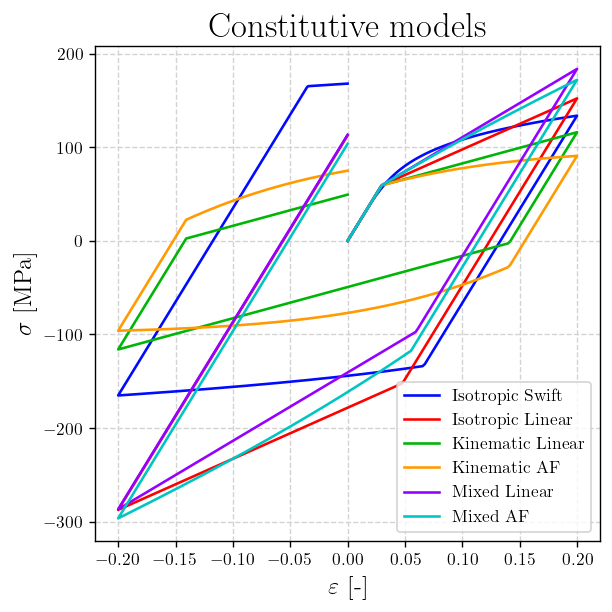

In [19]:
eps_max = 0.2

plt.figure(figsize=(5,5),dpi=125)
plt.title('Constitutive models',fontsize=20)
eps = np.concatenate([
    np.linspace(0,eps_max,200),
    np.linspace(eps_max,-eps_max,200),
    np.linspace(-eps_max,0,200)
])
for name, mat in materials.items():
    sig, _, _ = hardening(eps,mat['E'],mat['dalpha'],mat['Y'])
    plt.plot(eps,sig/1e6,color=materials[name]['color'],label=materials[name]['label'],lw=1.5)
plt.legend(loc='lower right',fontsize=10)
plt.xlabel(r'$\varepsilon$ [-]',fontsize=14)
plt.ylabel(r'$\sigma$ [MPa]',fontsize=14)
plt.grid(ls='--',c='lightgray')
plt.tight_layout()
plt.savefig(root / 'figures' / 'constitutive-models.png',dpi=250)
plt.show()

In [11]:
folder_path = Path('..','data','input','random')
random_inputs = [InputsSignals(file) for file in folder_path.iterdir()]

folder_path = Path('..','data','input','static')
static_inputs = [InputsSignals(file) for file in folder_path.iterdir()]

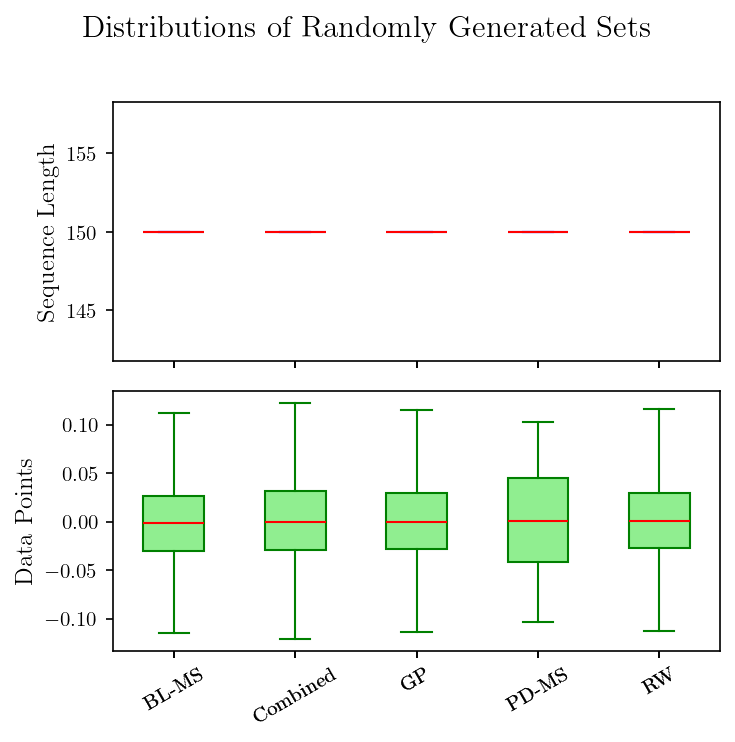

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(5, 5), dpi=150, sharex=True)
fig.suptitle('Distributions of Randomly Generated Sets', fontsize=15)

# Sequence lengths
ax[0].boxplot(
    [data.lengths for data in random_inputs],
    tick_labels=[readable(data.name) for data in random_inputs],
    showfliers=False,   # hide outliers
    patch_artist=True,  # fill boxes with color
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue')
)
ax[0].set_ylabel('Sequence Length', fontsize=12)

# Data points
ax[1].boxplot(
    [np.concatenate(data_set.u_list) for data_set in random_inputs],
    tick_labels=[readable(data_set.name) for data_set in random_inputs],
    showfliers=False,   # hide outliers
    patch_artist=True,
    boxprops=dict(facecolor='lightgreen', color='green'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='green'),
    capprops=dict(color='green')
)
ax[1].set_ylabel('Data Points', fontsize=12)

plt.xticks(rotation=30)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


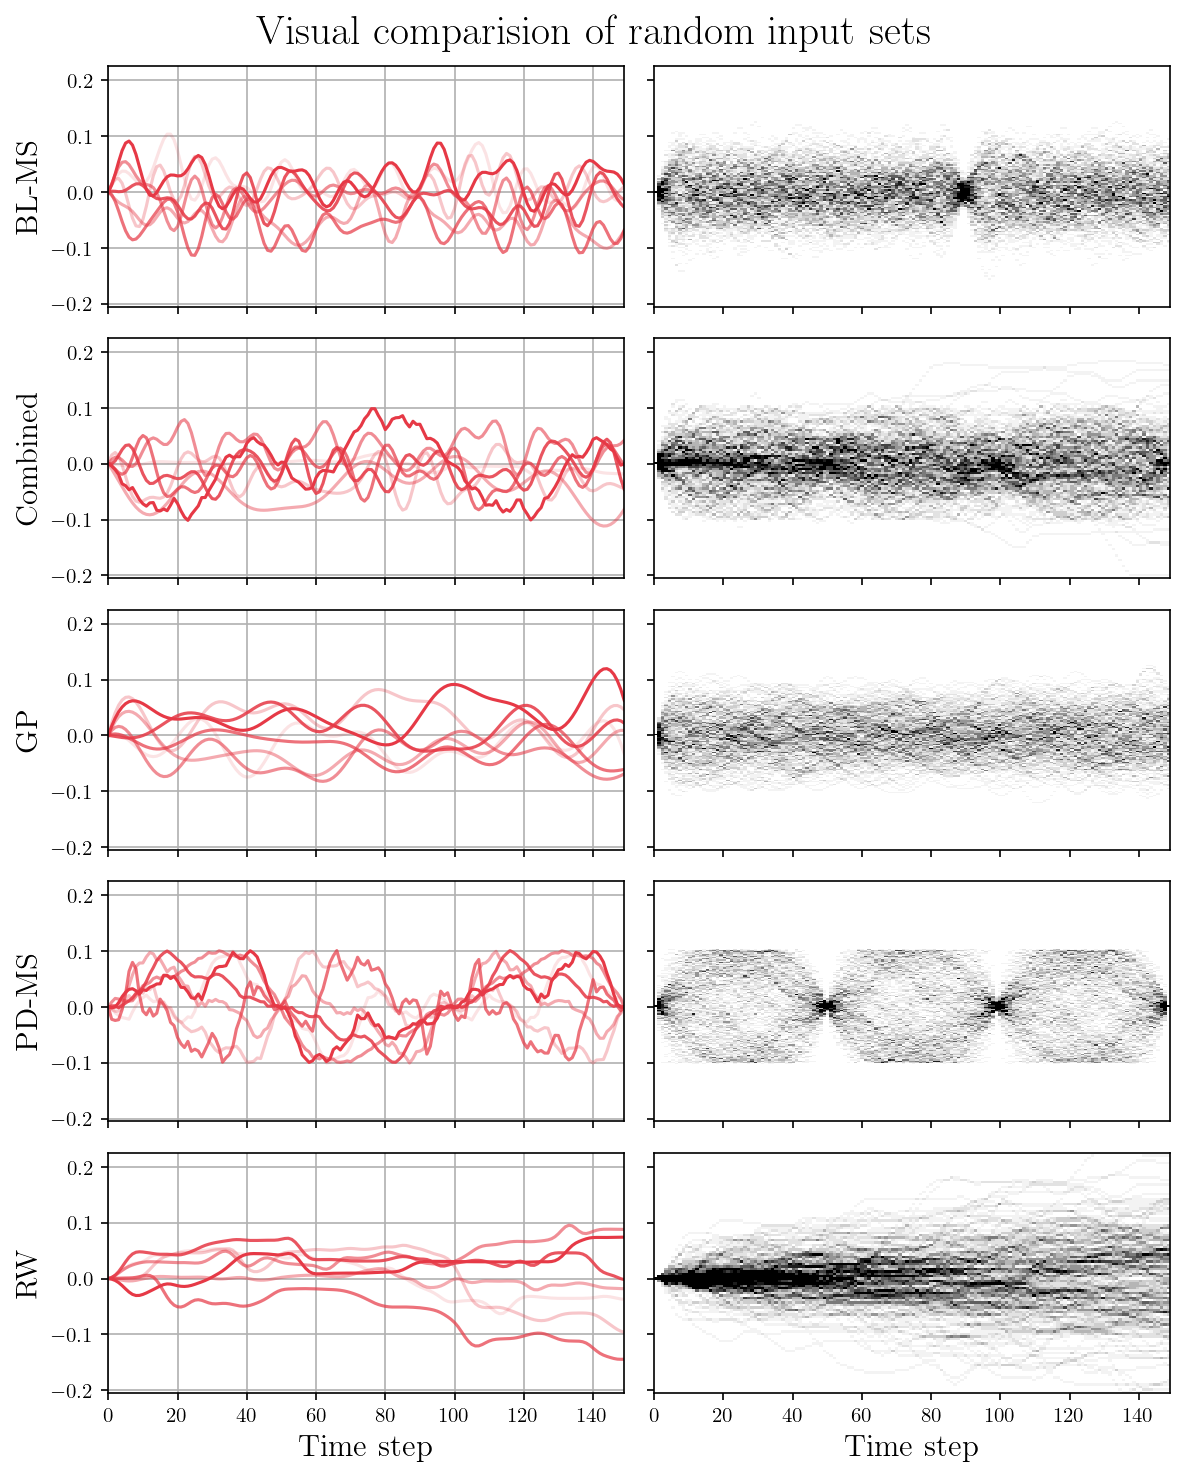

In [17]:
num = len(random_inputs)
fig, ax = plt.subplots(num,2,figsize=(8,2*num), dpi=150,sharex=True,sharey=True)
fig.suptitle('Visual comparision of random input sets',fontsize=20)

for i in range(num):
    random_inputs[i].plot_samples(ax=ax[i,0],num_samples=7)
    random_inputs[i].plot_histogram(ax=ax[i,1],bins_time=150,bins_value=100,vmin=0,vmax=10,cmap='Greys')
    ax[i,0].set_ylabel(f'{readable(random_inputs[i].name)}',fontsize=15)
ax[-1,0].set_xlabel('Time step',fontsize=15)
ax[-1,1].set_xlabel('Time step',fontsize=15)
plt.tight_layout()
plt.savefig(root / 'figures' / 'random-input-sets.png',dpi=250)
plt.show()

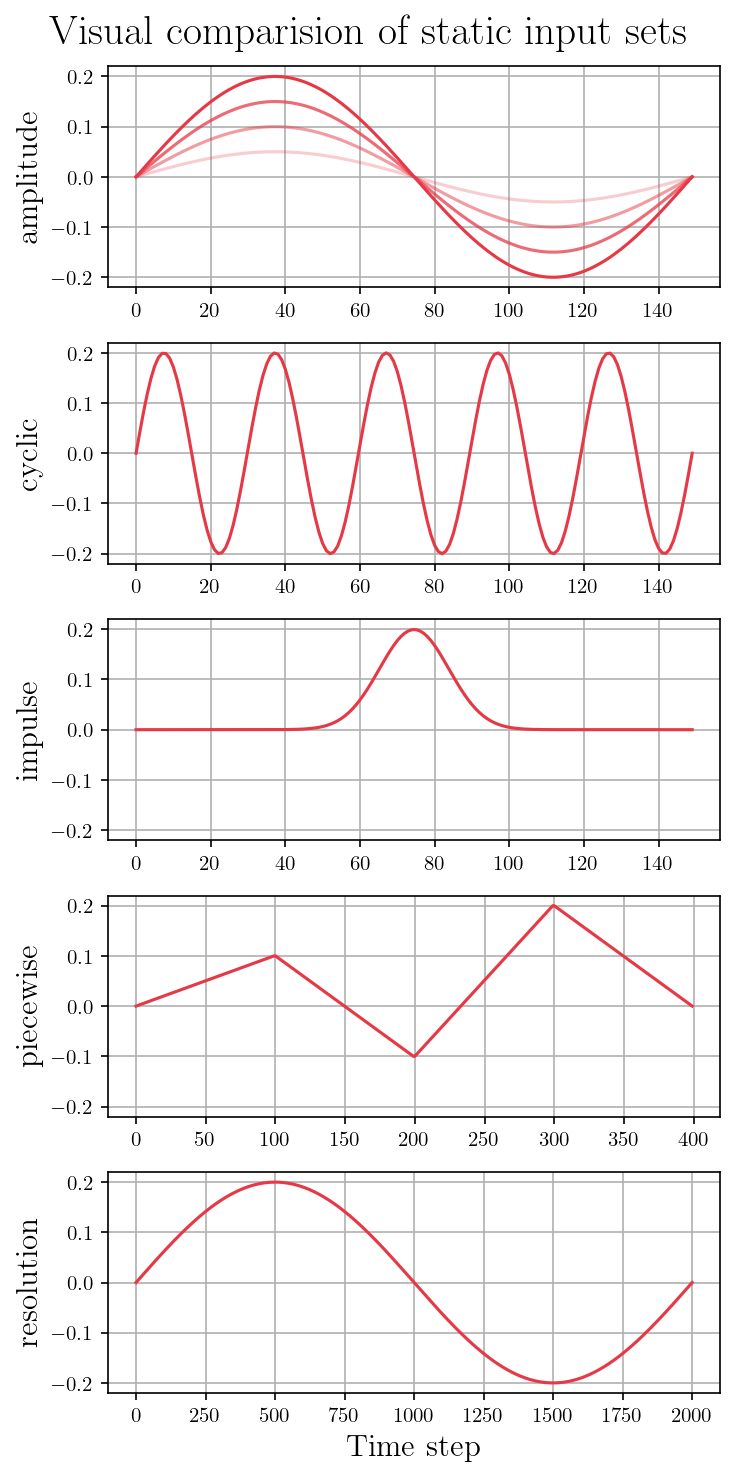

In [7]:
num = len(static_inputs)
fig, ax = plt.subplots(num,figsize=(5,2*num), dpi=150,sharex=False,sharey=True)
fig.suptitle('Visual comparision of static input sets',fontsize=20)

for i in range(num):
    static_inputs[i].plot_samples(ax=ax[i],num_samples=10)
    ax[i].set_ylabel(f'{static_inputs[i].name}',fontsize=15)
ax[-1].set_xlabel('Time step',fontsize=15)
plt.tight_layout()
plt.show()

# Check saved responeses

In [8]:
from data.materials import load_responses, plot_responses

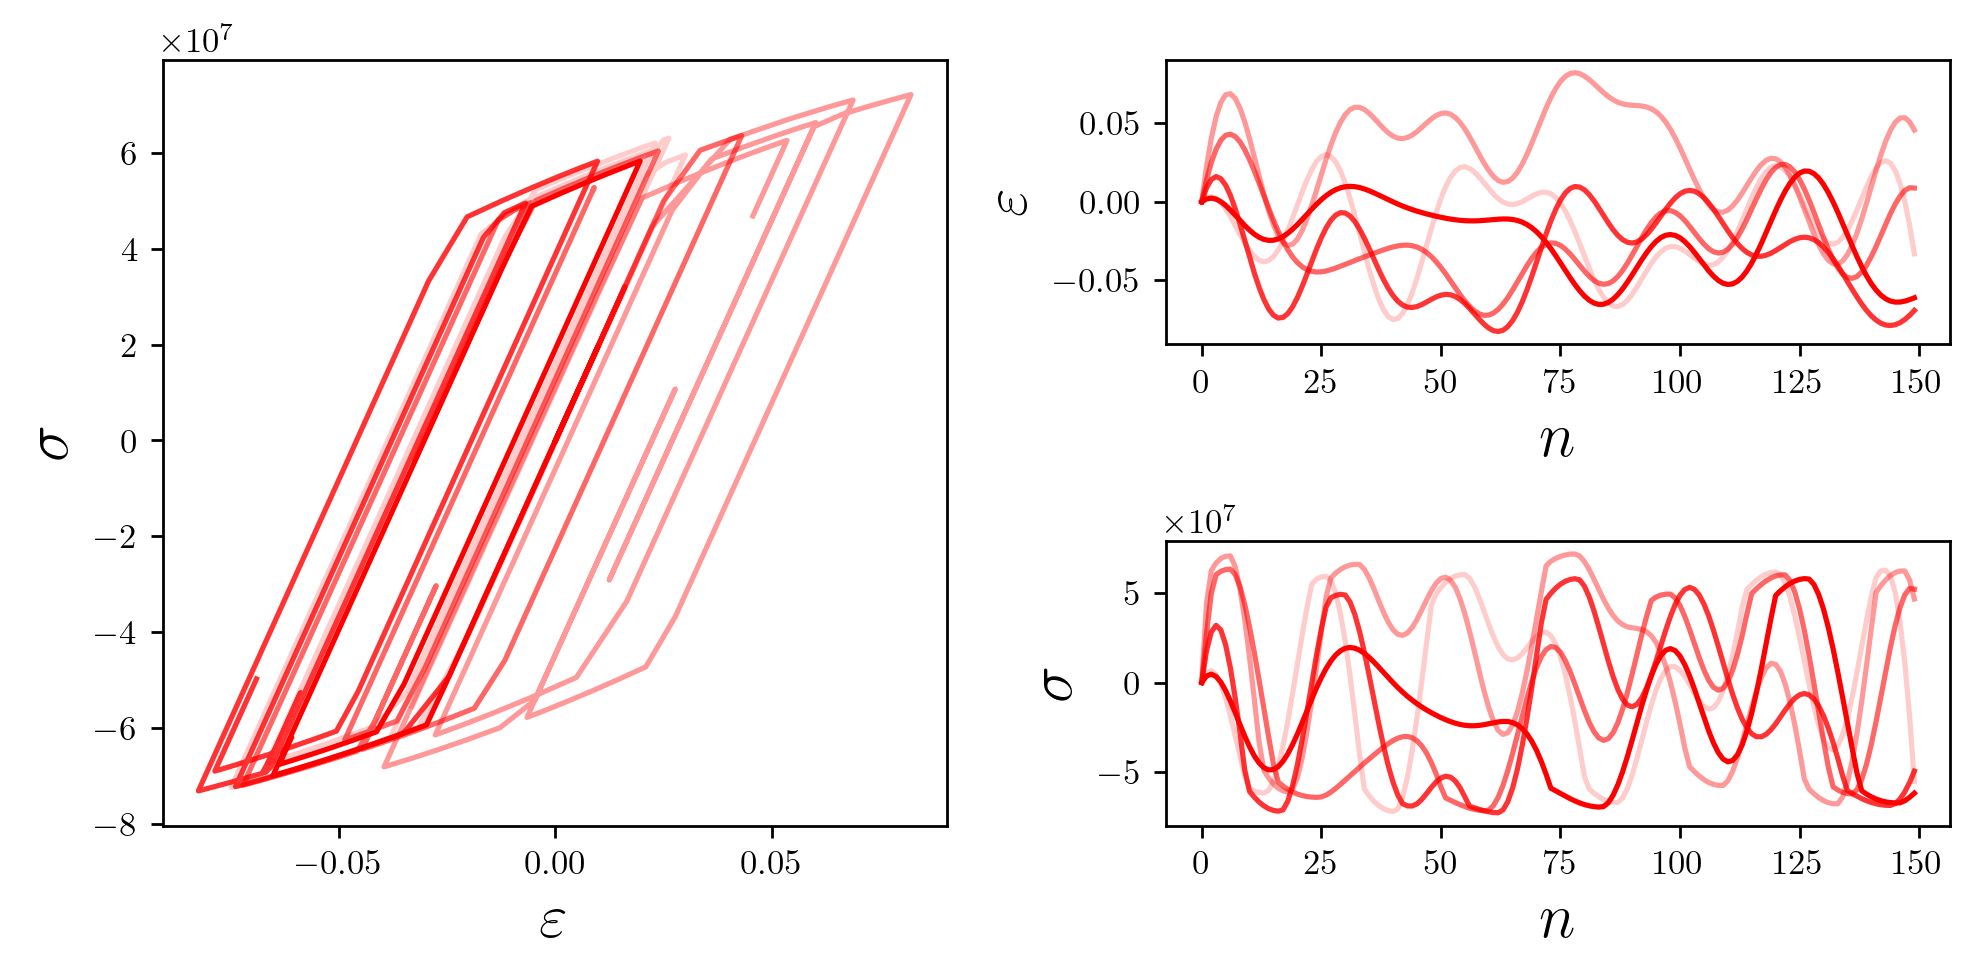

<Figure size 640x480 with 0 Axes>

In [9]:
mat_name = 'kinematic-armstrong-fredrick'
inp_type = 'random'
inp_name = 'gp_42_200'

eps_list, sig_list = load_responses(mat_name, inp_type, inp_name, data_dir='../data')
plot_responses(eps_list[:5], sig_list[:5])
plt.tight_layout()
plt.show()

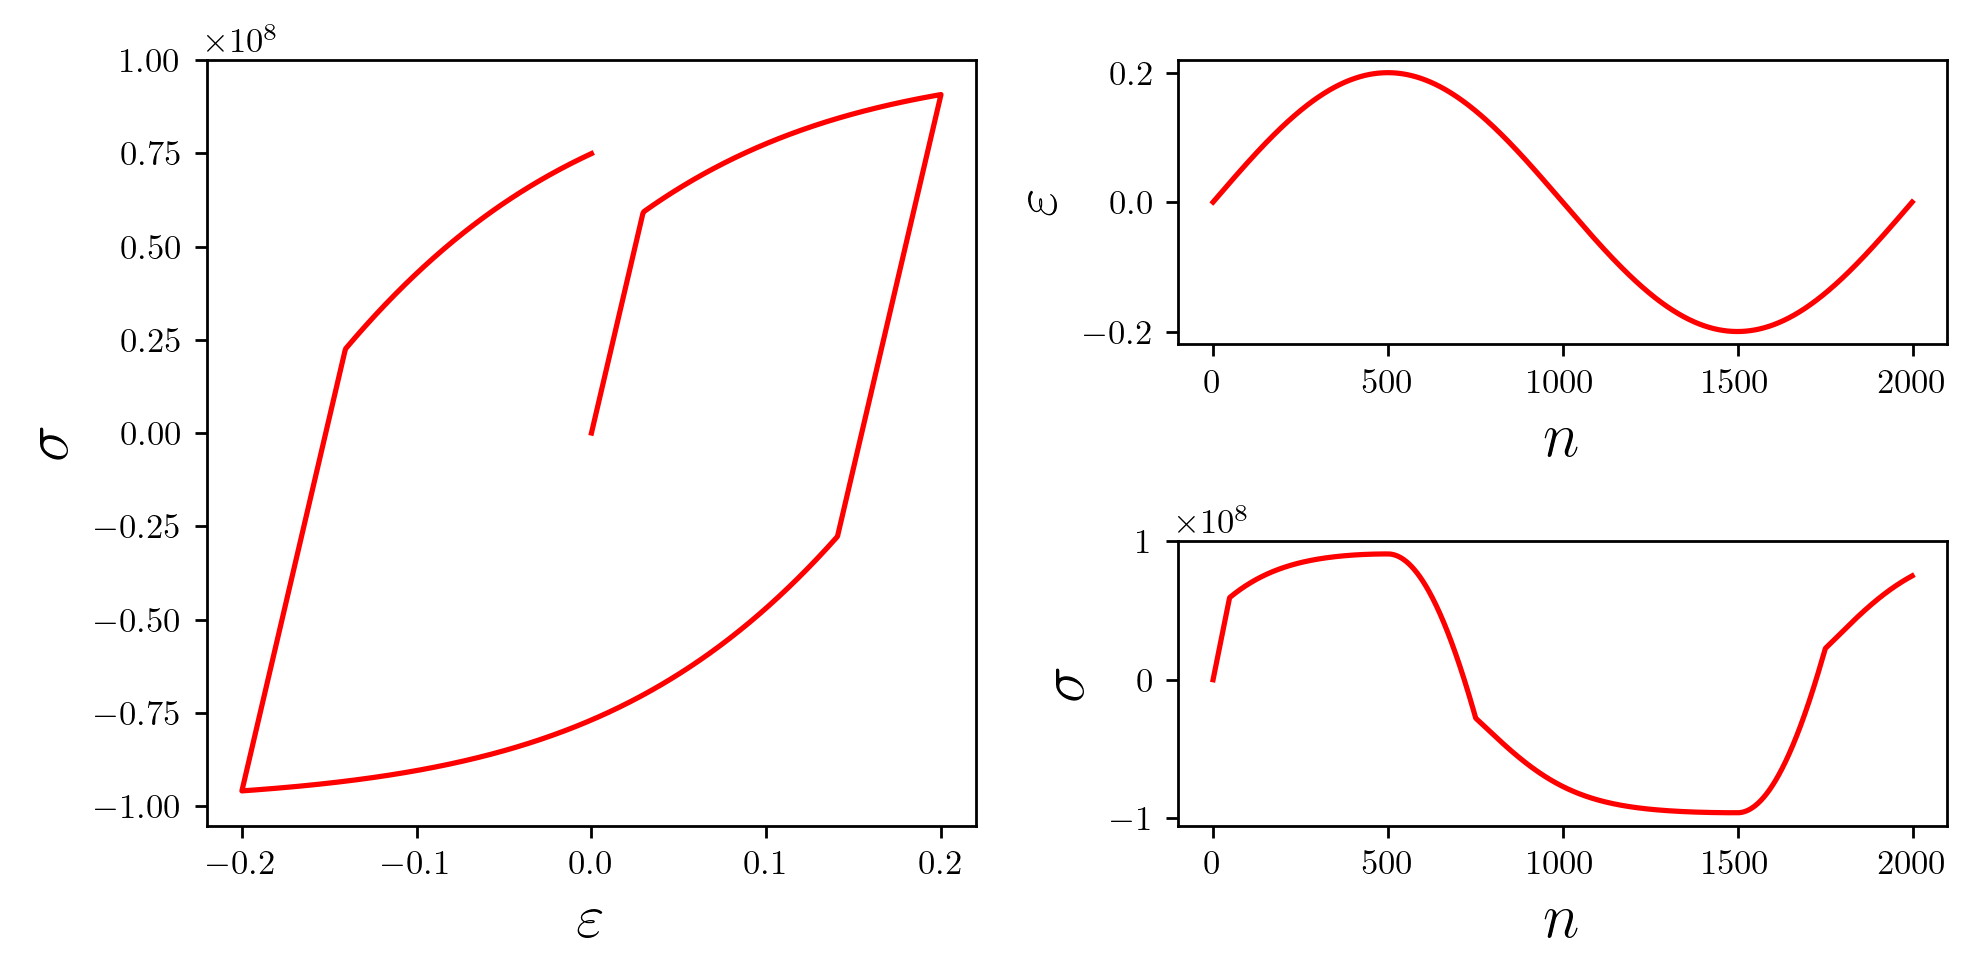

<Figure size 640x480 with 0 Axes>

In [10]:
mat_name = 'kinematic-armstrong-fredrick'
inp_type = 'static'
inp_name = 'resolution'

eps_list, sig_list = load_responses(mat_name, inp_type, inp_name, data_dir='../data')
plot_responses(eps_list[:5], sig_list[:5])
plt.tight_layout()
plt.show()

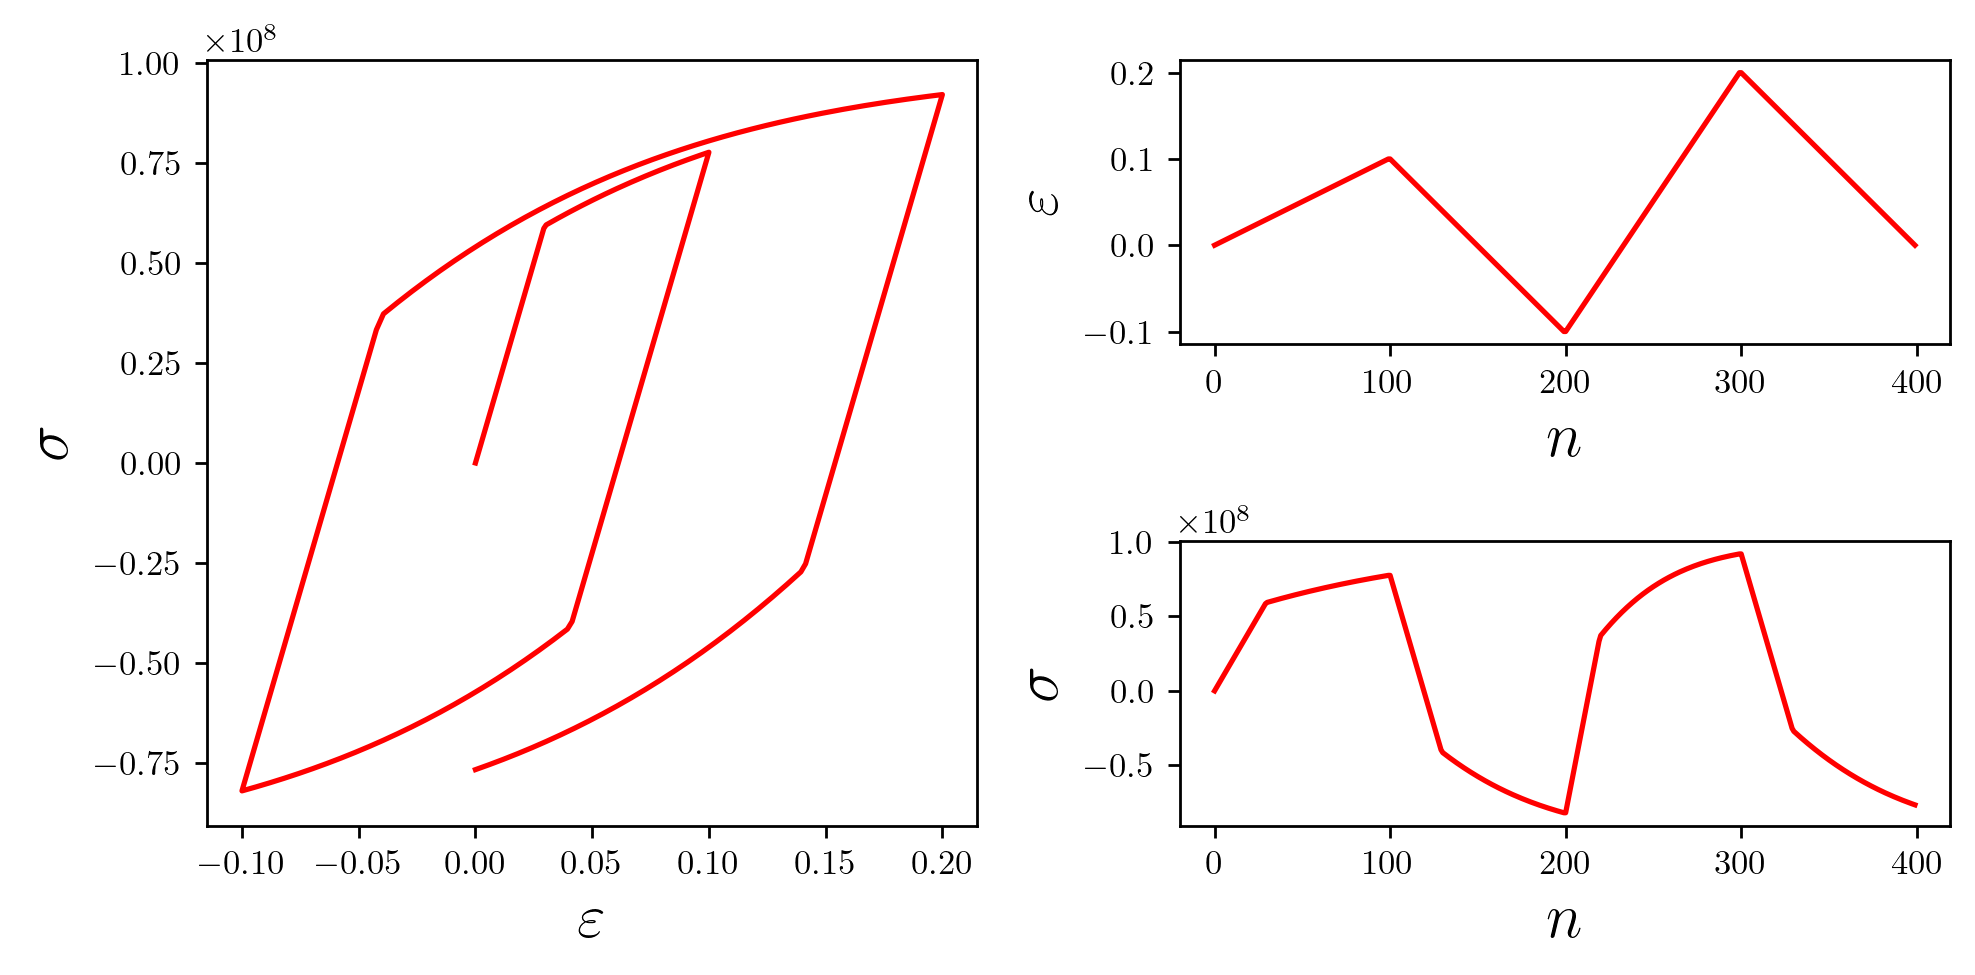

<Figure size 640x480 with 0 Axes>

In [11]:
mat_name = 'kinematic-armstrong-fredrick'
inp_type = 'static'
inp_name = 'piecewise'

eps_list, sig_list = load_responses(mat_name, inp_type, inp_name, data_dir='../data')
plot_responses(eps_list[:5], sig_list[:5])
plt.tight_layout()
plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---------------------------------------------------------
# 1) Sliding-window embedding
# ---------------------------------------------------------
def sliding_windows(x, window_size, step):
    n = len(x)
    starts = np.arange(0, n-window_size+1, step)
    windows = np.stack([x[s:s+window_size] for s in starts])
    return windows, starts

# ---------------------------------------------------------
# 2) Fő függvény: több idősor embedding + PCA + vizualizáció
# ---------------------------------------------------------
def plot_timeseries_variability(series_list, window_size=200, step=20):
    all_windows = []
    labels = []       # series id
    time_idxs = []    # window start positions

    # összegyűjtjük az ablakokat
    for sid, series in enumerate(series_list):
        wins, starts = sliding_windows(series, window_size, step)
        all_windows.append(wins)
        labels.extend([sid]*len(wins))
        time_idxs.extend(starts)

    # összevonás
    all_windows = np.vstack(all_windows)
    labels = np.array(labels)
    time_idxs = np.array(time_idxs)

    # standardizálás (opcionális)
    scaler = StandardScaler().fit(all_windows)
    X = scaler.transform(all_windows)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # ---------------------------------------------------------
    # 3) Plot 2D trajectory minden idősorra
    # ---------------------------------------------------------
    plt.figure(figsize=(6,6))
    n_series = len(series_list)

    for sid in range(n_series):
        pts = X_pca[labels == sid]
        plt.plot(pts[:,0], pts[:,1], linewidth=0.8, label=f"Series {sid}")
    
    plt.title(f"PCA sliding-window trajectories (window={window_size}, step={step})")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    return X_pca, labels, pca


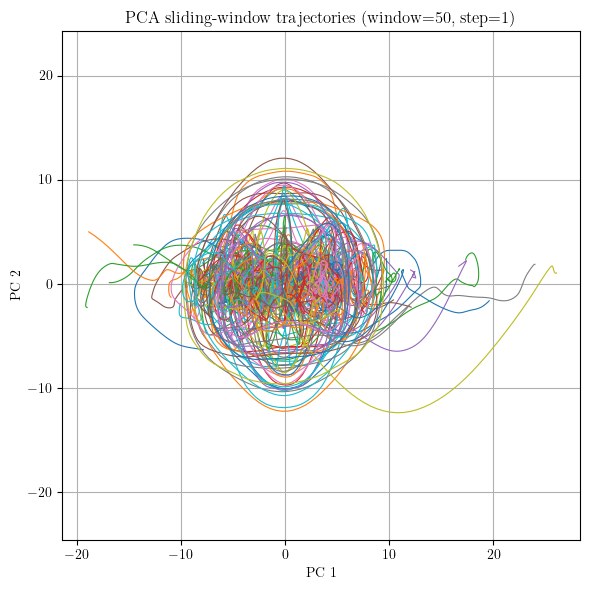

(array([[-8.4142931e-02, -6.2262681e-03],
        [-7.8835502e-02,  3.5863821e-03],
        [-7.0745654e-02,  1.2060440e-02],
        ...,
        [-8.9498081e+00, -2.1287942e+00],
        [-8.9785061e+00, -2.1639338e+00],
        [-9.0335960e+00, -2.1476939e+00]], dtype=float32),
 array([  0,   0,   0, ..., 199, 199, 199]),
 PCA(n_components=2))

In [39]:
inp_name = 'combined_42_200'

eps_list, _ = load_responses('kinematic-armstrong-fredrick', 'random', inp_name, data_dir='../data')
plot_timeseries_variability(eps_list[:,:,0], window_size=50, step=1)

In [41]:
from scipy.spatial.distance import pdist, squareform

def recurrence_plot(x, eps=None):
    x = np.asarray(x).reshape(-1,1)
    D = np.abs(x - x.T)
    if eps is None:
        eps = 0.1 * np.std(x)
    return (D < eps).astype(float)

def rp_distance_matrix(timeseries_list):
    RPs = [recurrence_plot(ts) for ts in timeseries_list]
    vec = [rp.flatten() for rp in RPs]
    D = squareform(pdist(vec, metric="euclidean"))
    return D

def mean_rp(timeseries_list):
    RPs = np.array([recurrence_plot(ts) for ts in timeseries_list])
    return RPs.mean(axis=0)

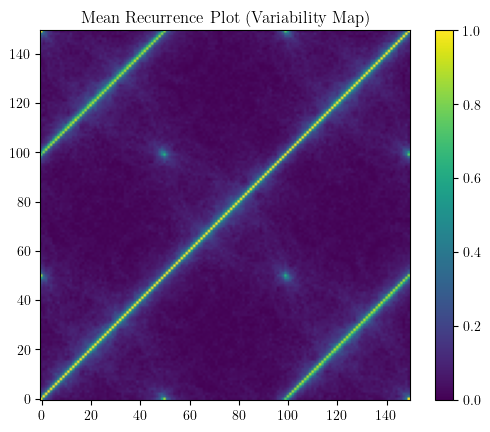

In [47]:
inp_name = 'pd_ms_42_200'

eps_list, _ = load_responses('kinematic-armstrong-fredrick', 'random', inp_name, data_dir='../data')

MRP = mean_rp(eps_list[:,:,0])

plt.imshow(MRP, cmap="viridis", origin="lower")
plt.title("Mean Recurrence Plot (Variability Map)")
plt.colorbar()
plt.show()